# Thêm thư viện cần thiết


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 8.4 MB/s 
     |████████████████████████████████| 9.8 MB 24.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [3]:
import pandas as pd
import warnings
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from sklearn.preprocessing import StandardScaler
from sklearn.utils import column_or_1d
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

warnings.filterwarnings('ignore')


# Nạp dữ liệu


In [4]:
train_XRP = pd.read_csv("/content/drive/My Drive/Năm 3/Làm nhóm HK2 2021 - 2022/Cá nhân/More/SF/Dataset/Data/8_2/xrp/xrp_train_8_2.csv", parse_dates=True, index_col=0)
train_XRP.head(5)

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2020-06-01,0.20254,0.21184,0.20132,0.21090,1662996864,USD
2020-06-02,0.21090,0.21452,0.19826,0.20317,2046863744,USD
2020-06-03,0.20316,0.20475,0.20104,0.20411,1226735360,USD
2020-06-04,0.20411,0.20713,0.20121,0.20438,1357705728,USD
2020-06-05,0.20438,0.20567,0.20174,0.20282,1165720704,USD


In [5]:
train = train_XRP[["Open"]]
train.head(5)

,Open
Date,
2020-06-01,0.20254
2020-06-02,0.21090
2020-06-03,0.20316
2020-06-04,0.20411
2020-06-05,0.20438


In [6]:
test_XRP = pd.read_csv("/content/drive/My Drive/Năm 3/Làm nhóm HK2 2021 - 2022/Cá nhân/More/SF/Dataset/Data/8_2/xrp/xrp_test_8_2.csv", parse_dates=True, index_col=0)
test_XRP.head(5)

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2022-01-07,0.77904,0.78057,0.72996,0.76260,688044608,USD
2022-01-08,0.76271,0.77617,0.72319,0.74471,471114432,USD
2022-01-09,0.74478,0.76650,0.73842,0.75283,307318528,USD
2022-01-10,0.75294,0.75892,0.70058,0.74013,566013632,USD
2022-01-11,0.74011,0.77445,0.73084,0.76986,495848448,USD


In [7]:
test = test_XRP[["Open"]]
test.head(5)

,Open
Date,
2022-01-07,0.77904
2022-01-08,0.76271
2022-01-09,0.74478
2022-01-10,0.75294
2022-01-11,0.74011


In [8]:
df = pd.concat([train.reset_index(level=0), test.reset_index(level=0)],    # Combine vertically
                          ignore_index = True,
                          sort = False)
df.index=df.Date
df.drop("Date", axis=1, inplace=True)
df.head(5)    

,Open
Date,
2020-06-01,0.20254
2020-06-02,0.21090
2020-06-03,0.20316
2020-06-04,0.20411
2020-06-05,0.20438


# Vẽ đồ thị

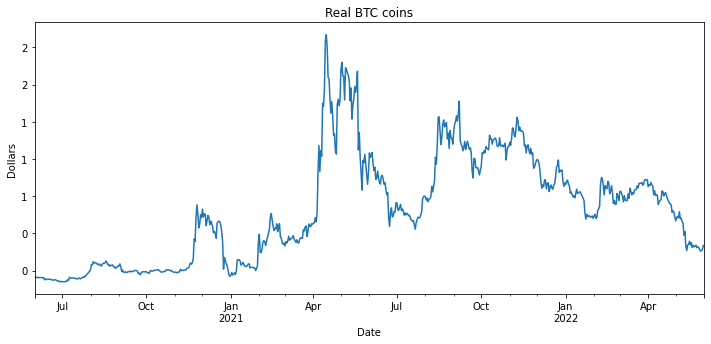

In [9]:
# Thư viện vẽ đồ thị
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

title = 'Real BTC coins'
ylabel='Dollars'
xlabel='Date' 

ax = df['Open'].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

# Kiểm tra tính dừng của chuỗi

In [10]:
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    # .dropna() handles differenced data
    result = adfuller(series.dropna(), autolag='AIC')

    labels = ['ADF test statistic', 'p-value',
              'Number of lags used', 'Number of observations']
    out = pd.Series(result[0:4], index=labels)

    for key, val in result[4].items():
        out[f'critical value ({key})'] = val

    # .to_string() removes the line "dtype: float64"
    print(out.to_string())

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non stationary")


In [11]:
adf_test(df['Open'], 'Bitcoin Price')


Augmented Dickey-Fuller Test: Bitcoin Price
ADF test statistic         -2.322406
p-value                     0.164843
Number of lags used        18.000000
Number of observations    712.000000
critical value (1%)        -3.439568
critical value (5%)        -2.865608
critical value (10%)       -2.568936
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non stationary


##### Nhận thấy p-value > 0.05, do đó chuỗi không phải là chuỗi dừng


# Lấy sai phân bậc 1 (d = 1) của chuỗi để kiểm định tính dừng


In [12]:
df['diff1'] = df['Open'].diff()
df.head()


,Open,diff1
Date,,
2020-06-01,0.20254,NaN
2020-06-02,0.21090,0.00836
2020-06-03,0.20316,-0.00774
2020-06-04,0.20411,0.00095
2020-06-05,0.20438,0.00027


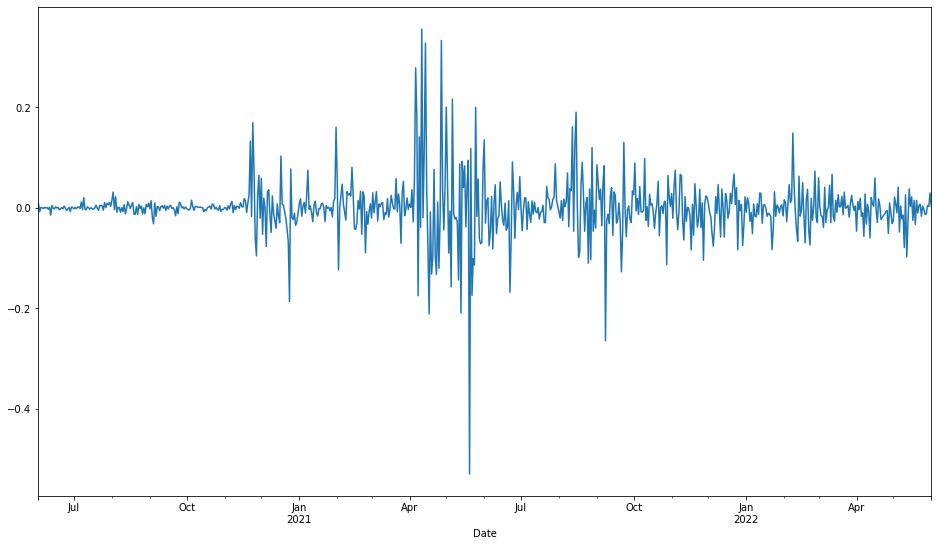

In [13]:
df['diff1'].dropna().plot(figsize=(16, 9))


# Kiểm định tính dừng của chuỗi tại sai phân bậc 1


In [14]:
adf_test(df['diff1'], 'Bitcoin Price at First Difference')


Augmented Dickey-Fuller Test: Bitcoin Price at First Difference
ADF test statistic       -5.996636e+00
p-value                   1.695465e-07
Number of lags used       1.800000e+01
Number of observations    7.110000e+02
critical value (1%)      -3.439581e+00
critical value (5%)      -2.865614e+00
critical value (10%)     -2.568939e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


##### Nhận thấy p-value < 0.05, do đó chuỗi có tính dừng tại sai phân bậc 1


# Thực hiện xây dựng mô hình ARIMA

## Cần chuẩn hóa dữ liệu để thuận tiện cho việc xây dựng mô hình

In [15]:
df_scaled = df.copy().drop(columns=['diff1'])

scaler = StandardScaler()

df_scaled['Open'] = scaler.fit_transform(df_scaled['Open'].values.reshape(-1, 1))
df_scaled.head()

,Open
Date,
2020-06-01,-1.265520
2020-06-02,-1.242443
2020-06-03,-1.263809
2020-06-04,-1.261186
2020-06-05,-1.260441


## Chia dữ liệu thành tập train và tập test

In [16]:
interrupt = len(train)
interrupt

585

In [17]:
index_test = df_scaled.index[interrupt:]
print(train.shape)
print(test.shape)
print(index_test.shape)

(585, 1)
(146, 1)
(146,)


In [18]:
train.tail()

,Open
Date,
2022-01-02,0.85003
2022-01-03,0.85867
2022-01-04,0.83183
2022-01-05,0.82271
2022-01-06,0.77137


In [19]:
test.head()

,Open
Date,
2022-01-07,0.77904
2022-01-08,0.76271
2022-01-09,0.74478
2022-01-10,0.75294
2022-01-11,0.74011


## Tìm các hệ số p, q và d phù hợp cho mô hình ARIMA

In [20]:
warnings.filterwarnings('ignore')


def arima_model(ts_data):
    fit_model = auto_arima(ts_data, test='adf', seasonal=False, trace=True)
    print(fit_model.summary())
    return fit_model


#### Dựa vào chỉ số AIC
- Chỉ số AIC càng thấp thì mô hình càng phù hợp

In [21]:
fitted = arima_model(train)
fitted.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1612.313, Time=1.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1614.082, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1614.489, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1614.455, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1615.931, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1612.495, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.987 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  585
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 808.965
Date:                Sun, 26 Jun 2022   AIC                          -1615.931
Time:                        02:34:24   BIC                          -1611.561
Sample:                             0   HQIC                         -1614.228
    

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  585
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 808.965
Date:                Sun, 26 Jun 2022   AIC                          -1615.931
Time:                        02:34:24   BIC                          -1611.561
Sample:                             0   HQIC                         -1614.228
                                - 585                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0037   7.02e-05     52.202      0.000       0.004       0.004
===================================================================================
Ljung-Box (L1) (Q):                   2.42   Jarque-Bera (JB):              6777.06
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):               4.85   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Dự đoán trên tập test


In [22]:
pred = fitted.predict(len(test))
pred


array([0.77137, 0.77137, 0.77137, 0.77137, 0.77137, 0.77137, 0.77137,
       0.77137, 0.77137, 0.77137, 0.77137, 0.77137, 0.77137, 0.77137,
       0.77137, 0.77137, 0.77137, 0.77137, 0.77137, 0.77137, 0.77137,
       0.77137, 0.77137, 0.77137, 0.77137, 0.77137, 0.77137, 0.77137,
       0.77137, 0.77137, 0.77137, 0.77137, 0.77137, 0.77137, 0.77137,
       0.77137, 0.77137, 0.77137, 0.77137, 0.77137, 0.77137, 0.77137,
       0.77137, 0.77137, 0.77137, 0.77137, 0.77137, 0.77137, 0.77137,
       0.77137, 0.77137, 0.77137, 0.77137, 0.77137, 0.77137, 0.77137,
       0.77137, 0.77137, 0.77137, 0.77137, 0.77137, 0.77137, 0.77137,
       0.77137, 0.77137, 0.77137, 0.77137, 0.77137, 0.77137, 0.77137,
       0.77137, 0.77137, 0.77137, 0.77137, 0.77137, 0.77137, 0.77137,
       0.77137, 0.77137, 0.77137, 0.77137, 0.77137, 0.77137, 0.77137,
       0.77137, 0.77137, 0.77137, 0.77137, 0.77137, 0.77137, 0.77137,
       0.77137, 0.77137, 0.77137, 0.77137, 0.77137, 0.77137, 0.77137,
       0.77137, 0.77

# Vẽ đồ thị cho tập test và kết quả dự đoán

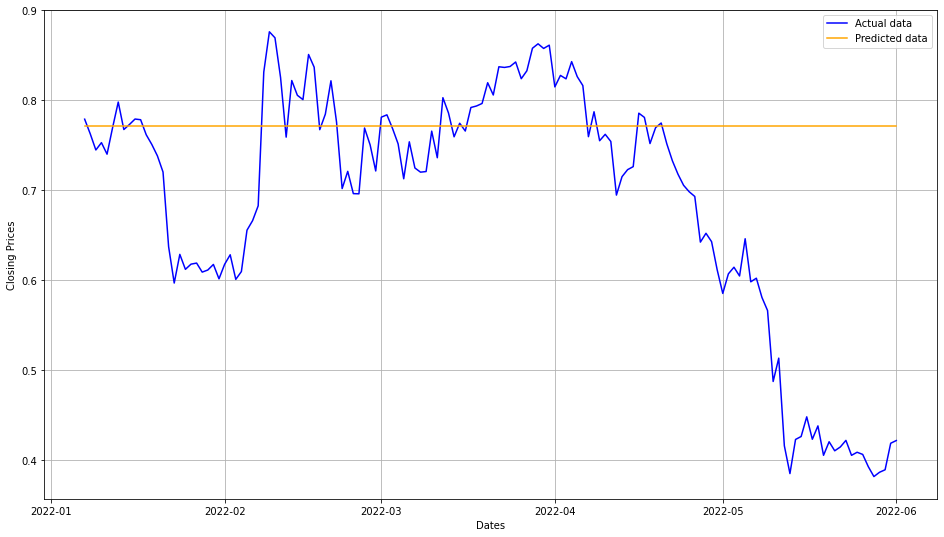

In [23]:
pred_series = pd.Series(pred, index=index_test)

plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(test, 'blue', label='Actual data')
plt.plot(pred_series, 'orange', label='Predicted data')
plt.legend()


# Đưa dữ liệu về miền giá trị ban đầu


In [24]:
actual = column_or_1d(test)
pred = column_or_1d(pred)

inv_actual = scaler.inverse_transform(actual.reshape(-1, 1))
inv_pred = scaler.inverse_transform(pred.reshape(-1, 1))


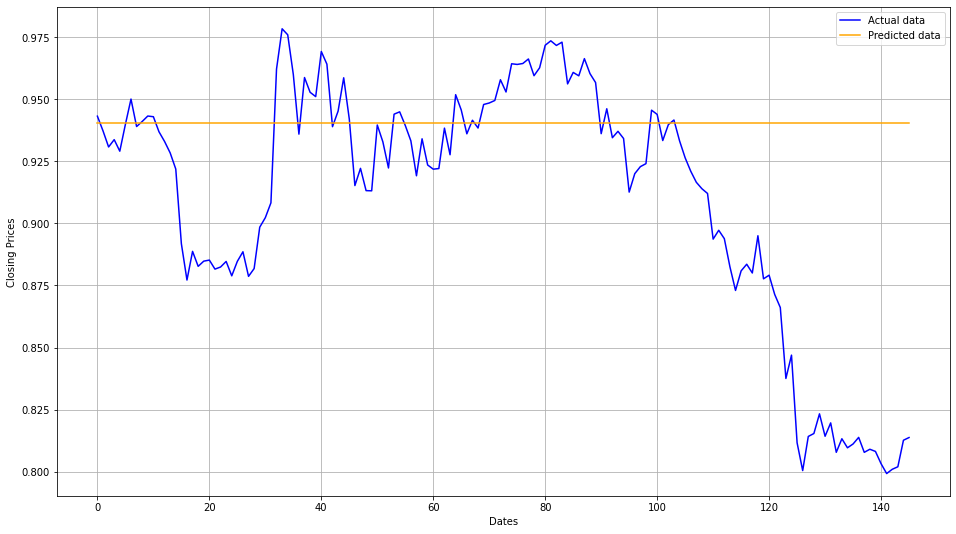

In [25]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(inv_actual, 'blue', label='Actual data')
plt.plot(inv_pred, 'orange', label='Predicted data')
plt.legend()


# Đánh giá mô hình qua các chỉ số MAE, MAPE, MSE, RMSE

In [26]:
# mae = mean_absolute_error(inv_actual, inv_pred)
mape = mean_absolute_percentage_error(inv_actual, inv_pred)
mse = mean_squared_error(inv_actual, inv_pred)
rmse = np.sqrt(mse)
r2 = r2_score(inv_actual, inv_pred)

# print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")
# print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")


MAPE: 4.69%
RMSE: 0.06
R2: -0.36
